In [1]:
import numpy as np
from cellpose import (
    core,
    models,
    denoise
)
from torch.utils.data import (
    ConcatDataset,
    DataLoader
)

import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

assert core.use_gpu() == 1, "No GPU detected"


In [2]:
model = denoise.CellposeDenoiseModel(gpu=1, model_type='cyto3', restore_type="denoise_cyto3")

## Dataset

In [3]:
import os
from typing import Tuple

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CellposeDataset(Dataset):
    images: list[np.ndarray]
    masks: list[np.ndarray]
    blend: float
    rng: np.random.Generator
    pdf: callable

    def __init__(self, path: str, blend: float = 1.):
        n_files = len(os.listdir(path))
        assert n_files % 2 == 0

        count = n_files // 2

        print("Loading images")
        self.images = list(map(
            lambda idx: np.array(Image.open("{}/{:03}_img.png".format(
                path, idx
            ))),
            range(count)
        ))

        print("Loading masks")
        self.masks = list(map(
            lambda idx: np.array(Image.open("{}/{:03}_masks.png".format(
                path, idx
            ))),
            range(count)
        ))
    
    def getRNG(self) -> np.random.Generator:
        return self.rng

    def __getitem__(self,idx: int) -> Tuple[np.array, np.array]:
        img = self.images[idx]
        return img/255., self.masks[idx]

    def __len__(self) -> int:
        return len(self.images)


In [4]:
dt = CellposeDataset("./test")

Loading images
Loading masks


# Images

In [ ]:
img, real_mask = dt[0]
masks, flows, styles, imgs_dn = model.eval(img, diameter=None, flow_threshold=None, channels=[2,1])
masks = ~np.isin(masks, [0])
real_mask = ~np.isin(real_mask, [0])

In [6]:
masks, flows, styles, imgs_dn = model.eval(img, diameter=None, flow_threshold=None, channels=[2,1])

In [7]:
from cellpose import utils
len(utils.outlines_list(masks))

90

In [8]:
list(map(
    lambda x: (np.max(x, axis=0), np.min(x, axis=0)),
    utils.outlines_list(masks)
))


[(array([120,  37]), array([69,  0])),
 (array([212,  28]), array([168,   0])),
 (array([280,  10]), array([261,   0])),
 (array([344,  25]), array([319,   0])),
 (array([511,  22]), array([431,   0])),
 (array([72, 57]), array([14,  1])),
 (array([21, 39]), array([0, 3])),
 (array([444,  53]), array([385,   7])),
 (array([169,  47]), array([129,  29])),
 (array([509,  49]), array([478,  30])),
 (array([304,  89]), array([239,  38])),
 (array([34, 92]), array([ 0, 42])),
 (array([503,  74]), array([468,  48])),
 (array([398,  98]), array([359,  55])),
 (array([135, 131]), array([87, 56])),
 (array([86, 95]), array([46, 59])),
 (array([332, 118]), array([247,  59])),
 (array([233,  96]), array([195,  61])),
 (array([511,  93]), array([497,  67])),
 (array([22, 98]), array([ 0, 68])),
 (array([174, 120]), array([137,  84])),
 (array([431, 139]), array([362,  86])),
 (array([492, 143]), array([428,  87])),
 (array([ 90, 108]), array([43, 89])),
 (array([246,  97]), array([235,  92])),
 (a

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

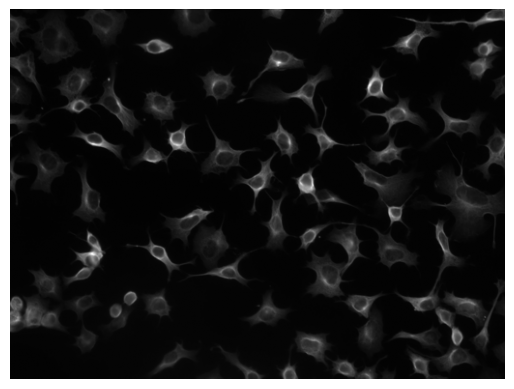

In [9]:
plt.imshow(img[:,:,1], cmap='gray')
plt.axis('off')

In [10]:
styles.shape

(256,)

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

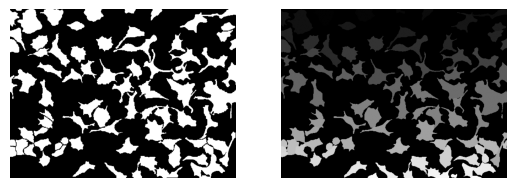

In [11]:
ax = plt.subplot(1, 2, 1)
ax.imshow(real_mask, cmap='gray')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(masks, cmap='gray')
ax.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

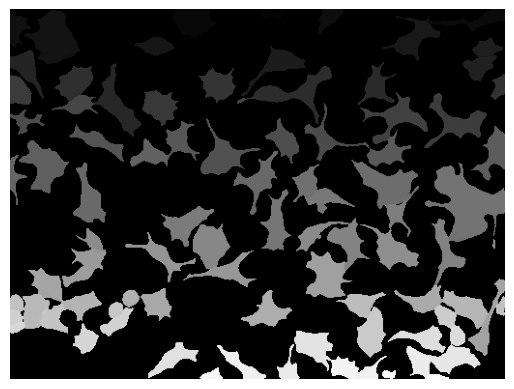

In [12]:
plt.imshow(masks ^ real_mask, cmap='gray')
plt.axis('off')

# Tests

In [5]:
noise_levels = np.arange(0., 1.01, 0.1)
noise_mean = 0
random_image_index = np.random.randint(0, len(dt))

In [6]:
def compute_acc_prec(masks: np.array, real_mask: np.array) -> tuple[float, float]:
    masks = np.isin(masks, [0])
    real_mask = np.isin(real_mask, [0])

    tot = masks.shape[0]*masks.shape[1]
    fp_plus_fn = np.count_nonzero(masks ^ real_mask)
    tp = np.count_nonzero(masks & real_mask)
    fp = np.count_nonzero(masks & ~real_mask)

    accuracy = 1 - fp_plus_fn / tot
    precision = tp / (tp + fp)
    avg_precision = tp / (tp + fp_plus_fn)

    return accuracy, precision, avg_precision

from multiprocessing.pool import ThreadPool

def compute_accuracy_and_precision(filter_ = None, pre_filter = None, channels = [2,1]) -> tuple[float, float]:
	def running_ex(i):
		print(f"{i} / {len(dt)}")
		img0, real_mask = dt[i]
		if pre_filter:
			img0, real_mask = pre_filter(img0, real_mask)
		img = img0
		if filter_ is not None:
			img = filter_(img, real_mask)
		norm = np.sqrt(((img0 - img) ** 2).sum())
		masks, flows, styles, imgs_dn = model.eval(img, diameter=None, flow_threshold=None, channels=channels)
		acc, prec, avg_prec = compute_acc_prec(masks, real_mask)
		return norm, acc, prec, avg_prec

	#pool = ThreadPool(4)
	#acc_prec = np.array(pool.map(running_ex, range(len(dt))))
	acc_prec = np.array(list(map(running_ex, range(len(dt)))))

	avg = acc_prec.mean(axis=0)
	std = acc_prec.std(axis=0)
	return [(avg[i], std[i]) for i in range(4)]


## First results for signal independant noises

In [7]:
from scipy.ndimage import gaussian_filter

In [ ]:
gaussian_std = np.arange(0., 3.01, 1.0)
noise_level = np.arange(0., 0.3+0.01, 0.03)
rng = np.random.default_rng()

output_normal_with_filter = []

for noise in noise_level:
    tmp = []
    for blur_std in gaussian_std:
        print(f"Testing dataset with noise of {noise} & blur {blur_std}")
        def img_filter(img: np.array, mask: np.array) -> np.array:
            out = gaussian_filter(img, sigma=blur_std) + noise * rng.normal(size=img.shape)
            return np.clip(out, 0., 1.)
        
        tmp.append(compute_accuracy_and_precision(img_filter))
    output_normal_with_filter.append(tmp)
output_normal_with_filter = np.array(output_normal_with_filter)

In [ ]:
output_poisson_with_filter = []
lam = 4.
noise_level = np.arange(0., 0.6+0.01, 0.03)
for noise in noise_level:
    tmp = []
    for blur_std in gaussian_std:
        print(f"Testing dataset with noise of {noise} & blur {blur_std}")
        def img_filter(img: np.array, mask: np.array) -> np.array:
            out = img
            if noise:
                out = np.random.poisson(
                    gaussian_filter(out, sigma=blur_std) * noise
                ) / noise
            return np.clip(out, 0., 1.)
        
        tmp.append(compute_accuracy_and_precision(img_filter))
    output_poisson_with_filter.append(tmp)
output_poisson_with_filter = np.array(output_poisson_with_filter)

In [17]:
def fixed_pattern(image, intensity, pattern_type="checkerboard"):
    """
    Adds fixed pattern noise to an image.

    Args:
        image (numpy.ndarray): Input image (grayscale or color).
        intensity (int): Maximum deviation for noise pattern (0-255).
        pattern_type (str): Type of pattern ('horizontal', 'vertical', 'grid', 'diagonal', 'checkerboard', 'sinusoidal', 'random_rows', 'random_columns').

    Returns:
        numpy.ndarray: Noisy image with fixed pattern noise.
    """
    # Get image dimensions
    height, width = image.shape[:2]

    # Generate different types of fixed pattern noise
    if pattern_type == "horizontal":
        pattern = np.tile(np.linspace(-intensity, intensity, width), (height, 1))

    elif pattern_type == "vertical":
        pattern = np.tile(np.linspace(-intensity, intensity, height), (width, 1)).T

    elif pattern_type == "grid":
        pattern = np.fromfunction(
            lambda y, x: ((x // 10) % 2 - 0.5) * intensity
            + ((y // 10) % 2 - 0.5) * intensity,
            (height, width),
        )

    elif pattern_type == "diagonal":
        pattern = np.fromfunction(
            lambda y, x: ((x + y) % 20 - 10) * (intensity / 10), (height, width)
        )

    elif pattern_type == "checkerboard":
        pattern = np.fromfunction(
            lambda y, x: ((x.astype(int) // 5 % 2) ^ (y.astype(int) // 5 % 2))
            * intensity,
            (height, width),
            dtype=int,
        )

    elif pattern_type == "sinusoidal":
        x_pattern = np.sin(np.linspace(0, np.pi * 4, width)) * intensity
        y_pattern = np.sin(np.linspace(0, np.pi * 4, height)) * intensity
        pattern = np.outer(y_pattern, x_pattern) / np.max(
            np.abs(y_pattern)
        )  # Normalize effect

    elif pattern_type == "random_rows":
        row_noise = np.random.uniform(-intensity, intensity, size=(height, 1))
        pattern = np.tile(row_noise, (1, width))

    elif pattern_type == "random_columns":
        col_noise = np.random.uniform(-intensity, intensity, size=(1, width))
        pattern = np.tile(col_noise, (height, 1))

    else:
        raise ValueError(
            "Invalid pattern type. Choose from 'horizontal', 'vertical', 'grid', 'diagonal', 'checkerboard', 'sinusoidal', 'random_rows', or 'random_columns'."
        )

    # Expand pattern for color images
    if len(image.shape) == 3:
        pattern = np.repeat(pattern[:, :, np.newaxis], 3, axis=2)

    # Convert image to float to prevent clipping issues
    noisy_image = image.astype(np.float32) + pattern

    # Add pattern noise and clip values
    # noisy_image = np.clip(image + pattern, 0, 255).astype(np.uint8)

    return noisy_image

patterns = ['horizontal', 'vertical', 'grid', 'diagonal', 'checkerboard', 'sinusoidal', 'random_rows', 'random_columns']

In [ ]:
output_fixed_with_filter = {}
noise_level = np.arange(0., 0.3+0.01, 0.03)

for pattern in patterns:
	print(f"Testing {pattern}")
	output_fixed_with_filter[pattern] = []
	for noise in noise_level:
		tmp = []
		for blur_std in gaussian_std:
			print(f"Testing dataset with noise of {noise} & blur {blur_std}")
			def img_filter(img: np.array, mask: np.array) -> np.array:
				out = gaussian_filter(img, sigma=blur_std)
				out = fixed_pattern(out, noise, pattern_type=pattern)
				return np.clip(out, 0., 1.)
			
			tmp.append(compute_accuracy_and_precision(img_filter))
		output_fixed_with_filter[pattern].append(tmp)
	output_fixed_with_filter[pattern] = np.array(output_fixed_with_filter[pattern])

In [7]:
def plot(axs, vals, subtext, show_std=False):
    axs[0].set_title("Accuracy")
    axs[0].errorbar(
        vals[:,0,0], vals[:,1,0],
        xerr=vals[:,0,1] if show_std else None,
        yerr=vals[:,1,1] if show_std else None,
        label=subtext
    )
    axs[1].set_title("Precision")
    axs[1].errorbar(
        vals[:,0,0], vals[:,2,0],
        xerr=vals[:,0,1] if show_std else None,
        yerr=vals[:,3,1] if show_std else None,
        label=subtext
    )
    axs[2].set_title("Average precision")
    axs[2].errorbar(
        vals[:,0,0], vals[:,3,0],
        xerr=vals[:,0,1] if show_std else None,
        yerr=vals[:,3,1] if show_std else None,
        label=subtext
    )
    axs[1].legend(fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncols=1)


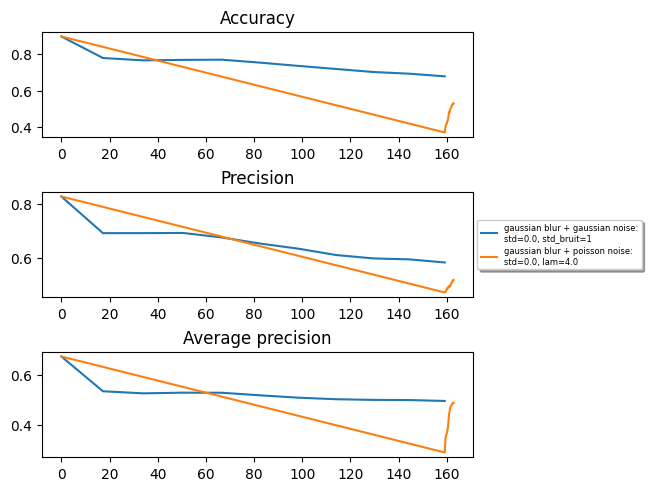

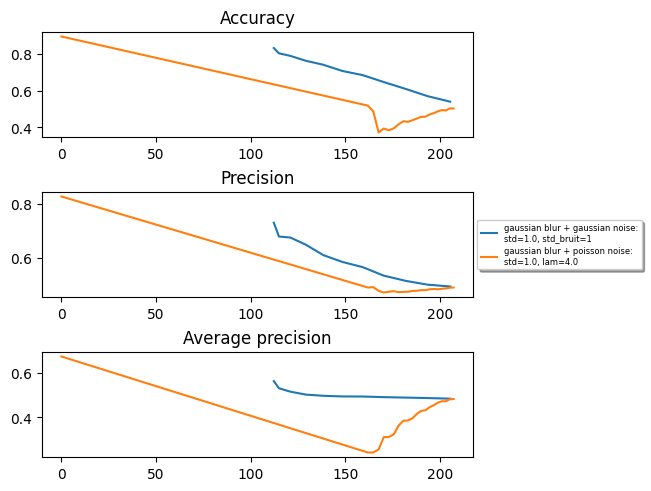

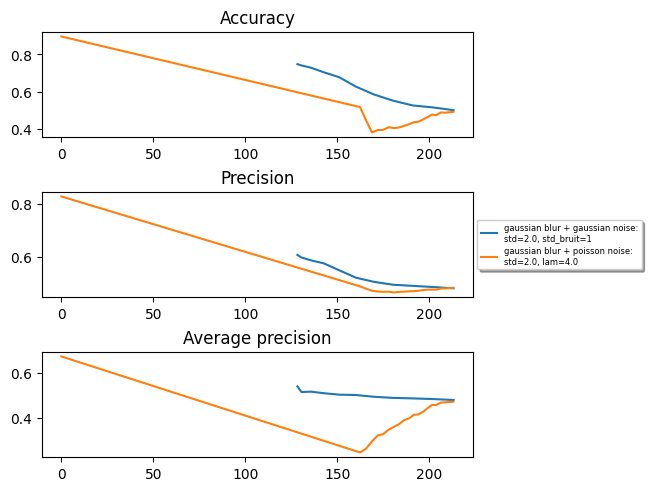

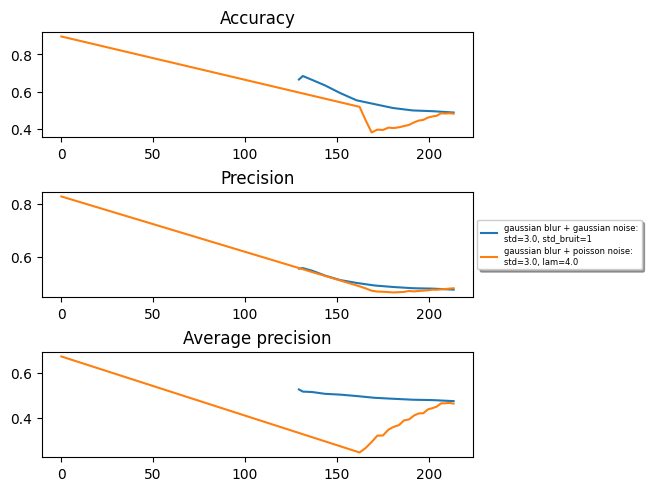

In [133]:
for i, std in enumerate(gaussian_std):
	fig, axs = plt.subplots(3, 1, constrained_layout=True)
	plot(axs, output_normal_with_filter[:,i], f"gaussian blur + gaussian noise:\nstd={std}, std_bruit=1")
	plot(axs, output_poisson_with_filter[:,i], f"gaussian blur + poisson noise:\nstd={std}, lam={lam}")
	plt.plot()
	plt.show()

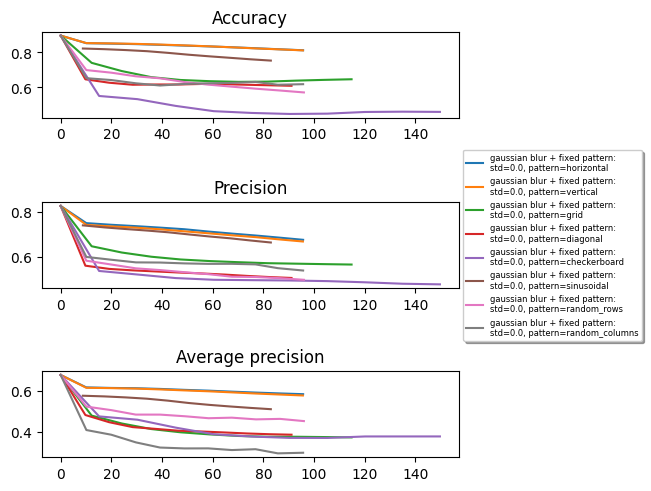

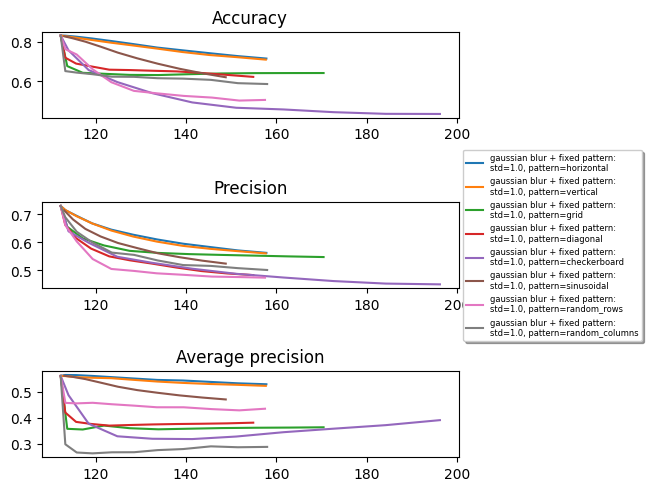

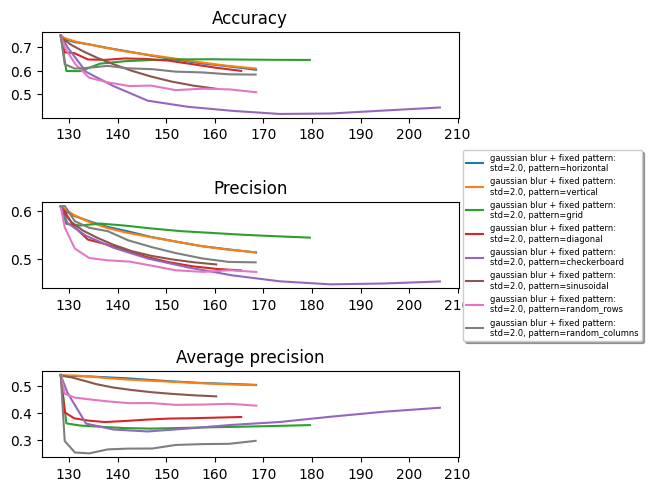

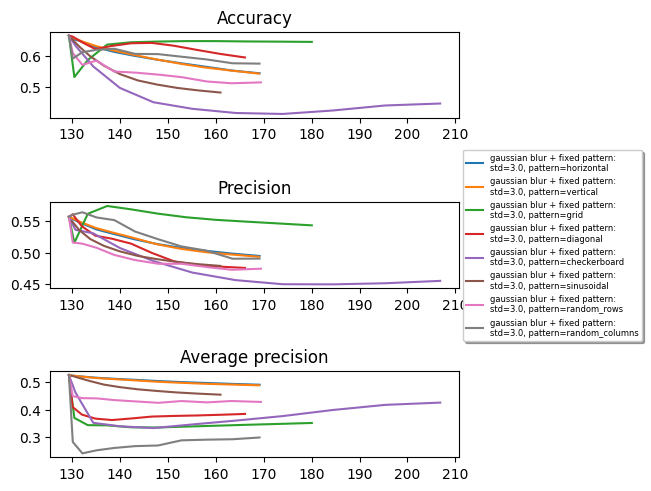

In [129]:
for i, std in enumerate(gaussian_std):
	fig, axs = plt.subplots(3, 1, constrained_layout=True)
	for pattern in patterns:
		vals = output_fixed_with_filter[pattern]
		plot(axs, vals[:,i], f"gaussian blur + fixed pattern:\nstd={std}, pattern={pattern}")

## Adversarial noise

In [8]:
def mod(a, b):
	out = a % b
	if out == 0:
		out = b
	return out

def transform(img, mask):
	img = img.transpose(2,0,1)
	pads = [(0, 0), (4 - mod(img.shape[1], 4), 0), (4 - mod(img.shape[2], 4), 0)]
	img = np.pad(img, pads, mode="constant")
	pads = pads[1:]
	mask = np.pad(mask, pads, mode="constant")
	return (img, mask)

In [9]:
TILE_SIZES = [8, 16, 32, 64]

### Adversarial noise (with denoiser U-Net as target)

In [10]:
def get_gradient_ascent(m, img, _mask, tile_size):
    img_width = img.shape[1]
    img_height = img.shape[2]
    img = img[[2, 0, 1], ...]

    def make_tiles(obj):
        return torch.from_numpy(np.array([
            obj[...,x:x+tile_size,y:y+tile_size]
            for x in range(0, img_width-tile_size+1, tile_size)
            for y in range(0, img_height-tile_size+1, tile_size)
        ])).to(m.device, dtype=torch.float32)

    tiles_tensor = make_tiles(img)
    tiles_tensor.requires_grad_(True)
    tiles_tensor.retain_grad()
    score = torch.zeros(1).to(m.device, dtype=torch.float32)
    for i in range(tiles_tensor.shape[0]):
        output_tensor = m.net(tiles_tensor[i].unsqueeze(1))[0]
        score += ((output_tensor - tiles_tensor[i])**2).sum()
    score.backward()
    grad_tensor = np.zeros(img.shape)
    with torch.no_grad():
        if tiles_tensor.grad is not None:
            i = 0
            grad = tiles_tensor.grad
            for y in range(0, img_height-tile_size+1, tile_size):
                for x in range(0, img_width-tile_size+1, tile_size):
                    grad_tensor[...,x:x+tile_size,y:y+tile_size] += grad[i].cpu().numpy()
                    i += 1
    return np.sign(grad_tensor[[1, 2, 0],...])

In [11]:
acc_and_prec_denoiser = []

for tile_size in TILE_SIZES:
	gs = {}
	tmp = []
	for noise in np.arange(0, 0.3+0.01, 0.03):
		print(f"Testing dataset with tilesize {tile_size}, noise {noise}")
		def img_filter(img, mask: np.array) -> np.array:
			h = hash(str(img) + str(img.shape))
			if h not in gs:
				gs[h] = get_gradient_ascent(model.dn, img, mask, tile_size)
			out = img + noise*gs[h]
			return np.clip(out, 0., 1.)
		tmp.append(compute_accuracy_and_precision(
			img_filter,
			pre_filter = transform
		))
	acc_and_prec_denoiser.append(tmp)
acc_and_prec_denoiser = list(map(np.array, acc_and_prec_denoiser))
acc_and_prec_denoiser = np.array(acc_and_prec_denoiser)

Testing dataset with tilesize 8, noise 0.0
0 / 68
1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68


/home/user/Devoirs/ProjetIntegrateur/ProjetInte/.venv/lib/python3.12/site-packages/cellpose/transforms.py:602: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn(


13 / 68
14 / 68
15 / 68
16 / 68
17 / 68
18 / 68
19 / 68
20 / 68
21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 14.31 MiB is free. Including non-PyTorch memory, this process has 4.81 GiB memory in use. Of the allocated memory 4.66 GiB is allocated by PyTorch, and 30.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
fig, axs = plt.subplots(3, 1, constrained_layout=True)
for i, size in enumerate(TILE_SIZES):
    vals = acc_and_prec_denoiser[i]
    plot(axs, vals, f"FSGM:\nTile size: {size}")

### Adversarial noise (with segmentation U-Net as target)

In [ ]:
from cellpose.dynamics import labels_to_flows

def get_gradient_ascent(m, img, mask, tile_size):
    img_width = img.shape[1]
    img_height = img.shape[2]
    img = img[[2, 1],...]
    def make_tiles(obj):
        return torch.from_numpy(np.array([
            obj[...,x:x+tile_size,y:y+tile_size]
            for x in range(0, img_width-tile_size+1, tile_size)
            for y in range(0, img_height-tile_size+1, tile_size)
        ])).to(m.device, dtype=torch.float32)

    tiles_tensor = make_tiles(img)
    tiles_tensor.requires_grad_(True)
    tiles_tensor.retain_grad()
    
    flow_tensor = labels_to_flows([mask], device = model.cp.device)[0]
    flow_vertical_tensor = make_tiles(flow_tensor[2])
    flow_horizontal_tensor = make_tiles(flow_tensor[3])

    output_tensor = m.net(tiles_tensor)[0]
    score = \
        ((output_tensor[:,1,...] - flow_horizontal_tensor)**2).sum() + \
        ((output_tensor[:,0,...] - flow_vertical_tensor)**2).sum()
    
    score.backward()
    grad_tensor = np.zeros((3,img_width, img_height))
    with torch.no_grad():
        if tiles_tensor.grad is not None:
            i = 0
            grad = tiles_tensor.grad
            for y in range(0, img_height-tile_size+1, tile_size):
                for x in range(0, img_width-tile_size+1, tile_size):
                    grad_tensor[2,x:x+tile_size,y:y+tile_size] += grad[i][0,...].cpu().numpy()
                    grad_tensor[1,x:x+tile_size,y:y+tile_size] += grad[i][1,...].cpu().numpy()
                    i += 1
    return np.sign(grad_tensor)

In [16]:
acc_and_prec = []

for tile_size in TILE_SIZES:
	gs = {}
	tmp = []
	for noise in np.arange(0, 0.3+0.01, 0.03):
		print(f"Testing dataset with tilesize {tile_size}, noise {noise}")
		def img_filter(img, mask: np.array) -> np.array:
			h = hash(str(img) + str(img.shape))
			if h not in gs:
				gs[h] = get_gradient_ascent(model.cp, img, mask, tile_size)
			out = img + noise*gs[h]
			return np.clip(out, 0., 1.)
		tmp.append(compute_accuracy_and_precision(
			img_filter,
			pre_filter = transform,
			channels = [0,2]
		))
	acc_and_prec.append(tmp)
acc_and_prec = list(map(np.array, acc_and_prec))
acc_and_prec = np.array(acc_and_prec)

54 / 68
44 / 68
60 / 68
65 / 68
59 / 68
66 / 68
61 / 68
67 / 68
62 / 68
63 / 68
64 / 68
Testing dataset with tilesize 128, noise 0.21
0 / 68
5 / 68
10 / 68
15 / 68
16 / 68
11 / 68
1 / 68
6 / 68
12 / 68
17 / 68
2 / 68
13 / 68
7 / 68
18 / 68
3 / 68
14 / 68
8 / 68
19 / 68
4 / 68
20 / 68
9 / 68
25 / 68
30 / 68
21 / 68
35 / 68
26 / 68
22 / 68
27 / 68
31 / 68
23 / 68
36 / 68
28 / 68
24 / 68
32 / 68
37 / 68
29 / 68
33 / 68
40 / 68
38 / 68
45 / 68
41 / 68
34 / 68
39 / 68
46 / 68
50 / 68
42 / 68
55 / 68
47 / 68
51 / 68
48 / 68
56 / 68
52 / 68
43 / 68
57 / 68
49 / 68
53 / 68
44 / 68
54 / 68
58 / 68
60 / 68
65 / 68
59 / 68
66 / 68
61 / 68
67 / 68
62 / 68
63 / 68
64 / 68
Testing dataset with tilesize 128, noise 0.24
0 / 68
5 / 68
10 / 68
15 / 68
16 / 68
1 / 68
11 / 68
6 / 68
17 / 68
12 / 68
2 / 68
7 / 68
18 / 68
13 / 68
3 / 68
8 / 68
14 / 68
19 / 68
4 / 68
9 / 68
20 / 68
25 / 68
30 / 68
35 / 68
21 / 68
26 / 68
31 / 68
27 / 68
36 / 68
22 / 68
28 / 68
23 / 68
32 / 68
37 / 68
29 / 68
24 / 68
33 / 68


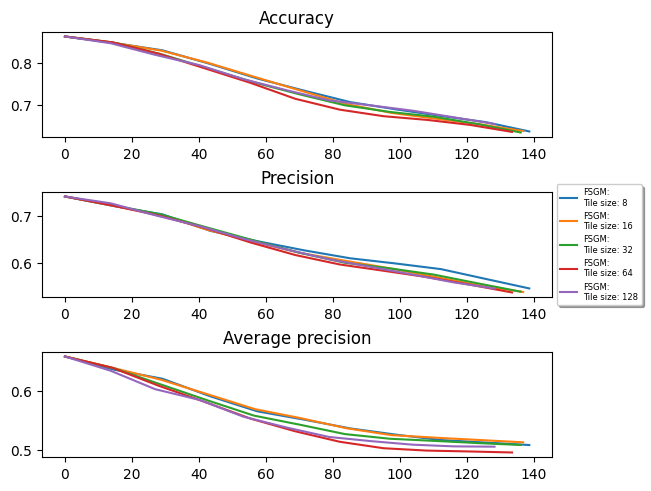

In [17]:
fig, axs = plt.subplots(3, 1, constrained_layout=True)
for i, size in enumerate(TILE_SIZES):
    vals = acc_and_prec[i]
    plot(axs, vals, f"FSGM:\nTile size: {size}")

## Other adversarial examples

## Genetic algorithm

https://arxiv.org/pdf/2104.15064

In [ ]:
help(cma)

Help on package cma:

NAME
    cma

DESCRIPTION
    Package `cma` implements the CMA-ES (Covariance Matrix Adaptation
    Evolution Strategy).

    CMA-ES is a stochastic optimizer for robust non-linear non-convex
    derivative- and function-value-free numerical optimization.

    This implementation can be used with Python versions >= 2.7, namely,
    it was tested with 2.7, 3.5, 3.6, 3.7, 3.8.

    CMA-ES searches for a minimizer (a solution x in :math:`R^n`) of an
    objective function f (cost function), such that f(x) is minimal.
    Regarding f, only a passably reliable ranking of the candidate
    solutions in each iteration is necessary. Neither the function values
    itself, nor the gradient of f need to be available or do matter (like
    in the downhill simplex Nelder-Mead algorithm). Some termination
    criteria however depend on actual f-values.

    The `cma` module provides two independent implementations of the
    CMA-ES algorithm in the classes `cma.CMAEvolutionStr

In [ ]:
help(cma.CMAEvolutionStrategy)

Help on class CMAEvolutionStrategy in module cma.evolution_strategy:

class CMAEvolutionStrategy(cma.interfaces.OOOptimizer)
 |  CMAEvolutionStrategy(x0, sigma0, inopts=None, options=None)
 |
 |  CMA-ES stochastic optimizer class with ask-and-tell interface.
 |
 |  Calling Sequences
 |  =================
 |
 |  - ``es = CMAEvolutionStrategy(x0, sigma0)``
 |
 |  - ``es = CMAEvolutionStrategy(x0, sigma0, opts)``
 |
 |  - ``es = CMAEvolutionStrategy(x0, sigma0).optimize(objective_fct)``
 |
 |  - ::
 |
 |      res = CMAEvolutionStrategy(x0, sigma0,
 |                              opts).optimize(objective_fct).result
 |
 |  Arguments
 |  =========
 |  `x0`
 |      initial solution, starting point. `x0` is given as "phenotype"
 |      which means, if::
 |
 |          opts = {'transformation': [transform, inverse]}
 |
 |      is given and ``inverse is None``, the initial mean is not
 |      consistent with `x0` in that ``transform(mean)`` does not
 |      equal to `x0` unless ``transform(mean

In [ ]:
x, y = 0, 0
width, height = 128, 128
imgb = dt[0][0][x:x+width,y:y+height,:]
mask = dt[0][1][x:x+width,y:y+height]

In [ ]:
img_vec = imgb.reshape(-1) / 255.
img_vec.shape

(49152,)

In [ ]:
xpot, es = cma.fmin2(lambda x: np.mean(compute_acc_prec(
    model.eval(
        x.reshape(imgb.shape),
        diameter=None,
        flow_threshold=None,
        channels=[2,1]
    )[0],
    mask
)),
img_vec,
0.2)

(383, 512, 3)

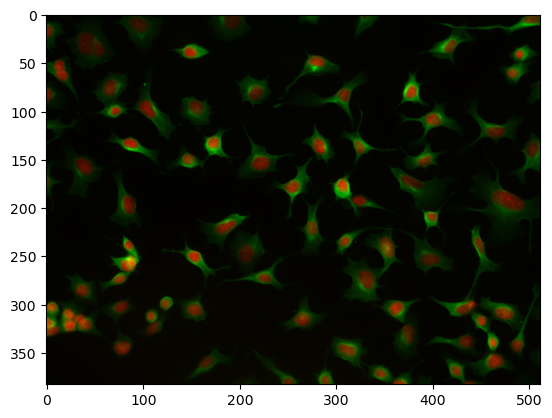

In [ ]:
img_vec_out = es.result.reshape(imgb.shape)
plt.imshow(img_vec_out)
imgb.shape